paper reference: https://arxiv.org/abs/1802.07465

**EXPLORE THE IDEA ON A DUMMY IMAGE**

In [3]:
from utility.utils import *

In [10]:
from skimage.morphology import *
import cv2
import numpy as np
import collections
import itertools

%matplotlib inline

In [5]:
def list_directory(path):
    if path[-1] != '/':
        path = path + '/'
    return [path + p for p in os.listdir(path)]

In [6]:
# path for a single sample
path = '../data/ds_bowl_2018/dummy/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9/'

In [7]:
# sample image
sample_image = list_files(path+'images')

# sample masks
sample_masks = list_files(path+'masks')

In [8]:
# read 2d - single channel image
def read2d(path): return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
# read 3d - single channel image
def read3d(path): return cv2.imread(path, cv2.IMREAD_COLOR)

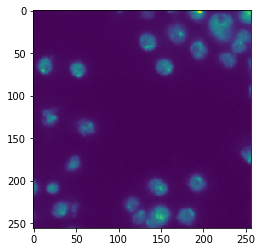

In [11]:
plt.imshow(read2d(sample_image[0]))

Note if we are going to treat each nuclei separately problematic cases should be dealt with, e.g. mask images with all 0 pixels, 2 nuclei masks in a single mask image, so on ...

In [12]:
# read each individual mask
mask_sum = 0
for mask in sample_masks:
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    plt.imshow(mask)
    #plt.show()
    mask_sum += mask
plt.close()

## Part 1: Custom Mapping from binary to 3 class (back, fore, boundary)

Can we leverage the fact that we now mask of each nuclei independently ? 

In [13]:
def get_contour_pos(mask):
    """
    Given a binary 2d mask this function will find contour positions of a mask
    
    Inputs:
        mask (np.array): binary 2d numpy array 
    Returns:
        contour_pos (list): list which has (i, j) positions for contour pixels as elements
    """
    if mask.max() != 1: 
        mask = mask / mask.max()
    H, W = mask.shape
    contour_pos = []
    for i in range(H):
        for j in range(W):
            # not edge
            m = []
            # N
            if (i) > 0:
                m.append(mask[i - 1, j])
            # S
            if (i) < H - 1:
                m.append(mask[i + 1, j])
            # E 
            if (j) < W - 1:
                m.append(mask[i, j + 1])
            # W
            if (j) > 0:
                m.append(mask[i, j - 1])
            if (min(m) == 0) and (mask[i, j] == 1):
                contour_pos.append((i, j))
    return contour_pos

In [14]:
def get_contour_arr(mask):
    """
    This function will take a binary mask array and will return the contour of the mask
    Inputs:
        mask (np.array): binary 2d numpy array 
    Returns:
        contour (np.array): binary 2d numpy array
    """
    if mask.max() != 1:
        mask_copy = mask.copy() / mask.max()
    mask_contour = mask_copy.copy()
    for i, j in get_contour_pos(mask_contour):
        mask_contour[i, j] = 2

    return (mask_contour - mask_copy)

In [15]:
def show_with_sz(image, sz=10):
    plt.figure(figsize=(sz, sz))
    plt.imshow(image)
    plt.show()
    plt.close()

In [16]:
mask_images = [read2d(mpath) for mpath in sample_masks]

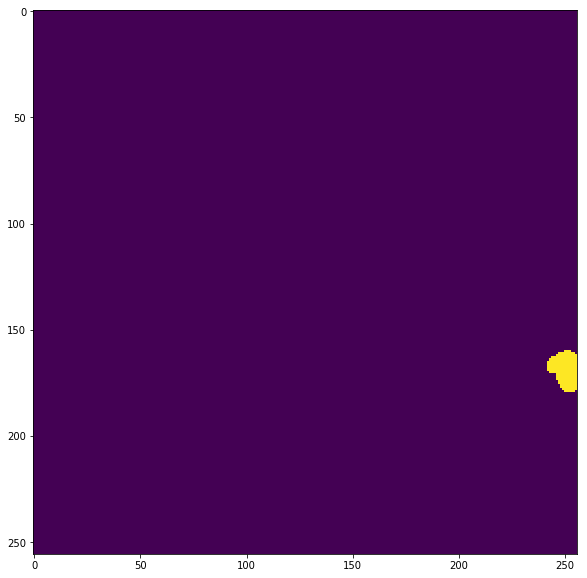

In [17]:
show_with_sz(mask_images[0])

In [18]:
contour_images = [get_contour_arr(mask) for mask in mask_images]

In [19]:
sum_contours = 0
for cntr in contour_images:
    sum_contours += cntr

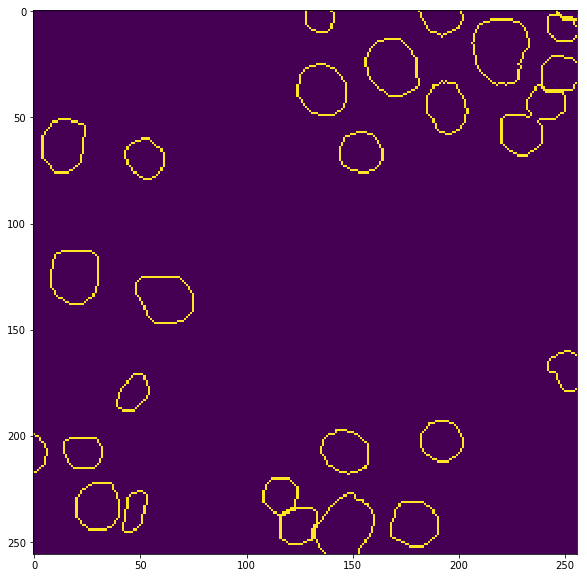

In [20]:
show_with_sz(sum_contours)

In [22]:
# get expanded contour at every directions
# this will be helpful for overlaps
# all 8 directions of movement in 2d
all_directions = set(itertools.permutations([1,1,-1, -1, 0, 0], 2))

def expand_contour(contour, directions=all_directions):
    """
    This function will expand a contour in a given set of directions by turning pixels into 1s
    Inputs:
        contour (np.array): Binary 2d numpy array which is the binary contour array
        directions (list): A list of tuples which has the movement addiiton in ith and jth position in tuples, e.g
        for moving left and right [(0, 1), (0, -1)], default is all 8 directions
    Returns:
        expanded_contour (np.array): Binary 2d numpy array which is the expanded contour array
    """
    
    expanded_contour = contour.copy()
    for i, j in zip(np.where(contour == 1)[0], np.where(contour == 1)[1]):
        for i_plus, j_plus in all_directions:
            try:
                expanded_contour[i + i_plus, j + j_plus] = 1
            except: continue # this is for the edges for now, not best practice but practical for fast solution
    return expanded_contour

In [23]:
expanded_contour_images = [expand_contour(contour) for contour in contour_images]

In [24]:
sum_expanded_contours = 0
for expanded_contour in expanded_contour_images:
    sum_expanded_contours += expanded_contour
sum_expanded_contours[sum_expanded_contours > 1] = 2

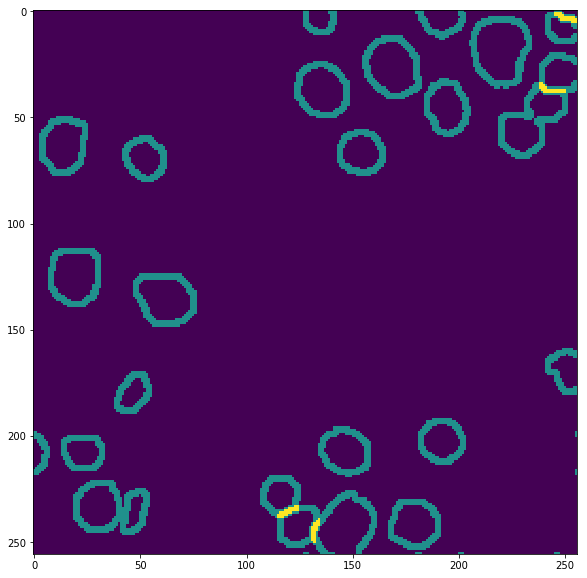

In [25]:
show_with_sz(sum_expanded_contours)

In [26]:
sum_mask_images = 0
for mask_image in mask_images:
    sum_mask_images += mask_image / 255 # make it binary

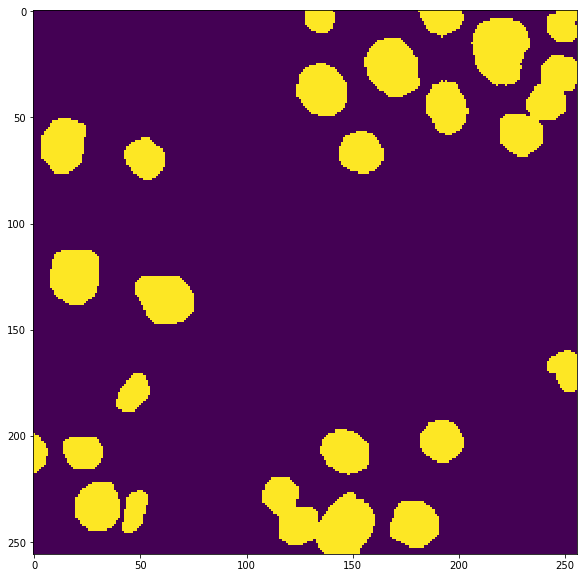

In [27]:
show_with_sz(sum_mask_images)

**COMBINE INFORMATION FROM SUM EXPANDED CONTOURS AND SUM MASK IMAGES**

This is definitely a a better job than trying to follow papers methodology which is a bit complex and unclear to implement.

Now we have 3 classes as follows: background:0, foreground:1, boundary:2

In [28]:
sum_mask_images[sum_expanded_contours == 2] = 2

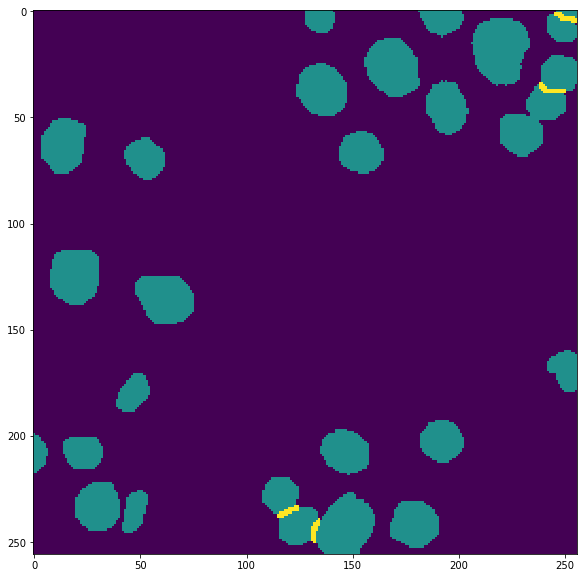

In [29]:
show_with_sz(sum_mask_images)

Here if we ignore background and 4 yellow boundaries, we perfectly match the number of nuclei provided in training set. Before using one mask image due to overlaps when using label function we were getting very bad results and this was effecting our score really really bad.

In [30]:
len(np.unique(label(sum_mask_images))) - 1 - 4
len(sample_masks)

27

#### Multiclass One Mask Pipeline

- Get sample mask paths
- Read sample mask images
- Get contour images 
- Get expanded contour images
- Calc sum expanded contour images
    - Clip pixels greater than 1 to 2
- Calc sum mask images
    - Filter sum mask images by sum expanded contour images ==2 and assign 2 

In [31]:
def list_files(path):
    """
    List files under a path
    """
    if path[-1] != '/':
        path = path + '/'
    return [path + p for p in os.listdir(path)]

def list_directory(path):
    """
    List directory under a path
    """
    if path[-1] != '/':
        path = path + '/'
    return [path + p + '/' for p in os.listdir(path)]


def multiclass_onemask(sample_masks):
    """
    This function will return a multiclass mask having the labels:
        0: background
        1: foreground
        2: overlap boundary - 2 nuclei sticked together
        
    Inputs:
        sample_masks (list): a list of path of individual masks belonging to the same image
    """
    # get mask images
    mask_images = [read2d(mpath) for mpath in sample_masks]
    # get contour images
    contour_images = [get_contour_arr(mask) for mask in mask_images]
    # create expanded contour images
    expanded_contour_images = [expand_contour(contour) for contour in contour_images]
    # sum and assign to expanded contour images
    sum_expanded_contours = 0
    for expanded_contour in expanded_contour_images:
        sum_expanded_contours += expanded_contour
    sum_expanded_contours[sum_expanded_contours > 1] = 2
    # sum mask images and draw overlap boundaries
    sum_mask_images = 0
    for mask_image in mask_images:
        sum_mask_images += mask_image / 255 # make it binary
    sum_mask_images[sum_expanded_contours == 2] = 2
    
    return sum_mask_images

In [32]:
valid_dirs = list_directory('../data/ds_bowl_2018/valid/')

In [33]:
i = 5 # i th sample
sample_image = list_files(valid_dirs[i] + 'images/') # sample image
sample_masks = list_files(valid_dirs[i] + 'masks/') # sample masks

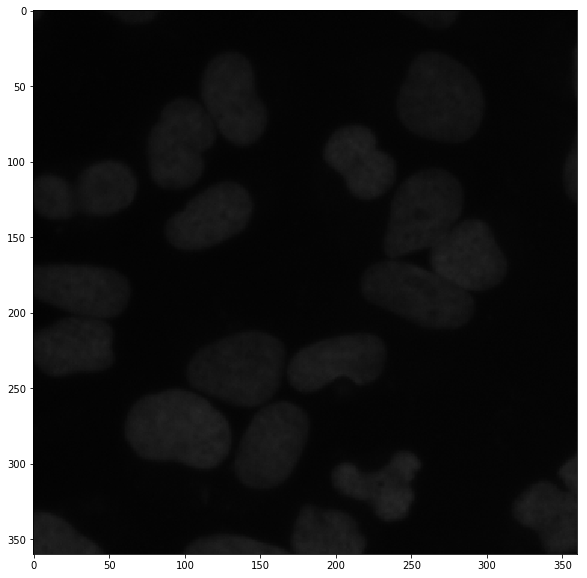

In [34]:
show_with_sz(read3d(sample_image[0]))

In [35]:
mclass_mask = multiclass_onemask(sample_masks)

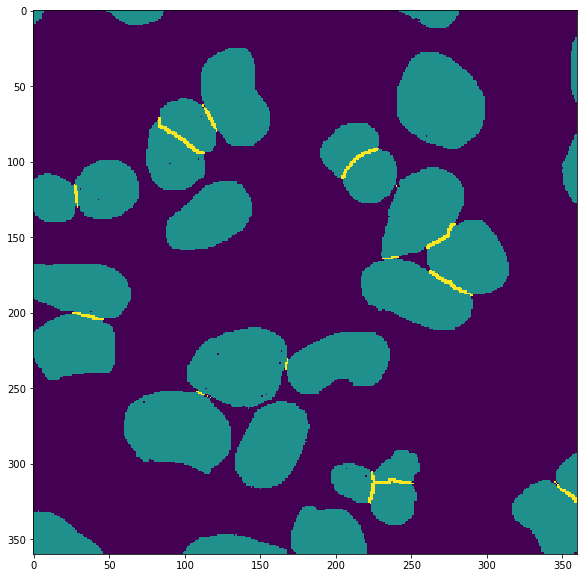

In [36]:
show_with_sz(mclass_mask)

In [37]:
# include only foreground and background for label evaluation
final_mask_eval = mclass_mask.copy()
final_mask_eval[final_mask_eval == 2] = 0

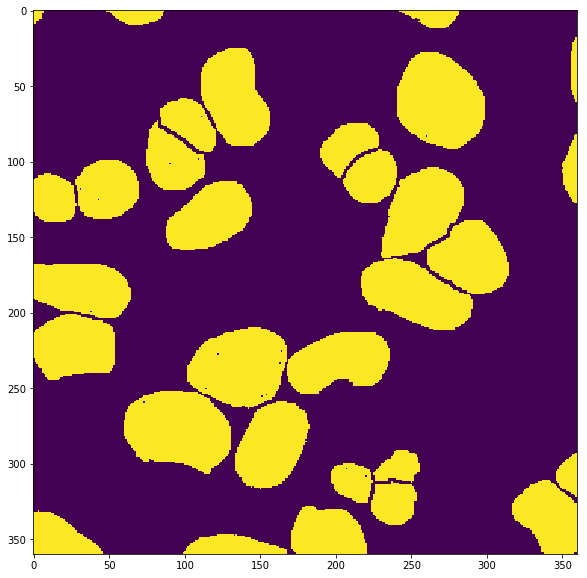

In [38]:
show_with_sz(final_mask_eval)

In [39]:
# exclude background and check if it matches
len(np.unique(label(final_mask_eval))) - 1, len(sample_masks)

(31, 31)

#### Create Multiclass One Mask for every image

We will create multiclass one mask iamges for each sample like we did in one mask before under full train directory. Because when we create new train and valid sets from full data we would like to copy everything including one_mask as well as mclass_one_mask.

In [40]:
MAIN_PATH = '../data/ds_bowl_2018/full_data/'

In [41]:
data_dirs = list_directory(MAIN_PATH)

In [42]:
data_dirs[1], len(data_dirs) 

('../data/ds_bowl_2018/full_data/8bef203fce625e4d8c89dca728158be4662dfdfdcd4dc73a6aa39a908c1631bc/',
 670)

In [43]:
from joblib import Parallel, delayed

def create_mclass_masks(dir_):
    sample_image = list_files(dir_ + 'images/') # list of sample image, a single image for each sample
    sample_masks = list_files(dir_ + 'masks/') # list of sample masks paths
    mclass_mask = multiclass_onemask(sample_masks)
    plt.imsave(dir_ + 'mclass_one_mask.png', mclass_mask)

results = Parallel(n_jobs=-1, backend="threading")(
             map(delayed(create_mclass_masks), data_dirs))

In [45]:
mclass_mask = read2d(data_dirs[-1] + 'mclass_one_mask.png')

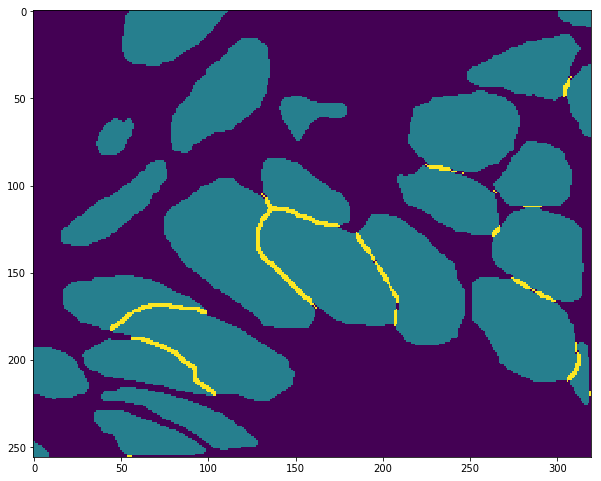

In [46]:
show_with_sz(mclass_mask)

In [47]:
# Pixel Intensity Mapping

#If there are 3 unique pixel intensities
# 30 : Background
# 110 : Nuclei
# 215 : Overlap Boundary

#If there are 2 unique pixel intensities
# 30 : Background
# 215 : Nuclei

np.unique(mclass_mask)

array([ 30, 110, 215], dtype=uint8)

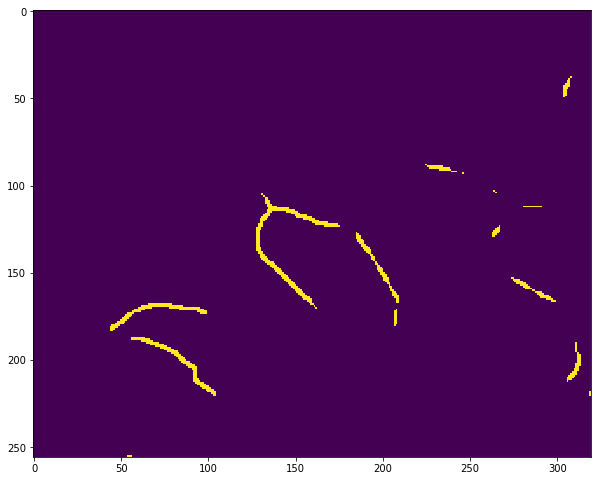

In [48]:
show_with_sz(mclass_mask == 215)

#### Algorithm 1 from paper for binary to 3 class mapping

Doesn't work well ! Our heuristic approach works better.

In [ ]:
# structuring element
selem = square(3)

dilated1 = dilation(mask_sum_bin, selem)
erosion1 = erosion(dilated1, selem)
erosion2 = erosion1 - mask_sum_bin
dilated2 = dilation(erosion2, selem)
final_mask_sum = mask_sum_bin + (np.max(mask_sum_bin) + 1)*dilated2

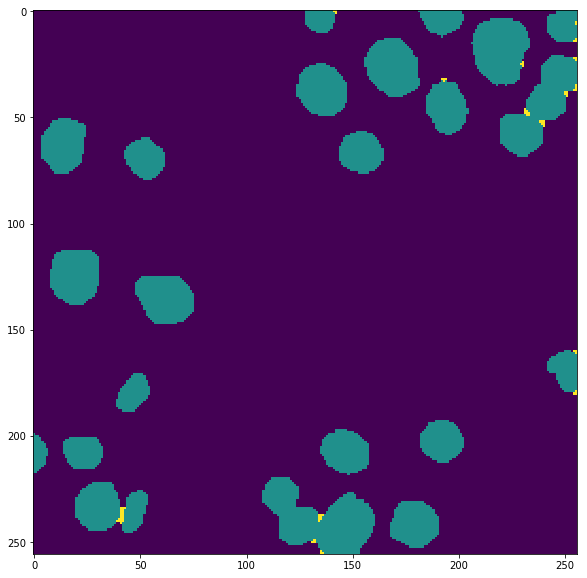

In [205]:
plt.figure(figsize=(10, 10))
final_mask_sum[final_mask_sum == 3] = 1
plt.imshow(final_mask_sum)

## Part 2: Defining Weights

#### 1- Distance Transform Based Weight Map (DWM)

# Pixel Intensity Mapping

If there are 3 unique pixel intensities

- 30 : Background
- 110 : Nuclei
- 215 : Overlap Boundary

If there are 2 unique pixel intensities

- 30 : Background
- 215 : Nuclei

#### weights

w DW M (p, β) = w 0 (p) (1 − min (φ g (p)/β, 1))

- Find w0 : 1 / |g| number of pixels for that class, g0 > g1 > g2

### 1 -  Using just class weights

In [27]:
# for non-background w = w0
# w = w0*(1 - min(phi / beta, 1))

In [3]:
MAIN_PATH = '../data/ds_bowl_2018/full_data/'

In [4]:
data_dirs = list_directory(MAIN_PATH)

In [5]:
data_dirs[:5]

['../data/ds_bowl_2018/full_data/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/',
 '../data/ds_bowl_2018/full_data/8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832/',
 '../data/ds_bowl_2018/full_data/c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7/',
 '../data/ds_bowl_2018/full_data/5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8/',
 '../data/ds_bowl_2018/full_data/2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d/']

In [31]:
tot_background = 0
tot_nuclei = 0
tot_overlap = 0

for i in range(len(data_dirs)):
    files = list_files(data_dirs[i])
    mclass_mask = read2d(files[2])
    if len(np.unique(mclass_mask)) == 2:
        tot_background += np.sum(mclass_mask == 30) # background
        tot_nuclei += np.sum(mclass_mask == 215) # nuclei
    else:
        tot_background += np.sum(mclass_mask == 30) # background
        tot_nuclei += np.sum(mclass_mask == 110) # nuclei
        tot_overlap += np.sum(mclass_mask == 215) # overlap

In [38]:
w_background, w_nuclei, w_overlap  =\
    1 / ((tot_background, tot_nuclei, tot_overlap) / (tot_background + tot_nuclei + tot_overlap))

In [39]:
w_background, w_nuclei, w_overlap

(1.1551767249306626, 7.544967099214484, 557.753645718466)

### 2 -  Using normalized regional weights